## Can GPT4 Solve the ARC Challenge?
This notebook was created by John Tan Chong Min on 17 Apr 2023.
- Seek to use GPT4 via zero-shot prompt engineering to generate an output
- Fine-tuning the prompt to let GPT4 ground its answer has proven effective
- Works quite well for grids with small sizes
- Can be better if we ask GPT4 to generate the python code for its description, and use it to check validity based on input/output pairs.
- Can be even better if we have GPT4s with different biases and grounding, and increase diversity of possible generated code

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import copy

def load_json_data(folder):
    json_files = [pos_json for pos_json in os.listdir(folder) if pos_json.endswith('.json')]
    data = {}
    for js in json_files:
        with open(os.path.join(folder, js)) as json_file:
            data[js] = json.load(json_file)
    return data

def plot_2d_grid(data):
    cvals  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    colors = ["black", "dodgerblue", "red", "lightgreen", "yellow", "grey", "magenta", "orange", "lightblue", "brown"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    fig, axs = plt.subplots(1, 3, figsize=(5, len(data['test']) * 3))
    print(axs.shape)
    axs[0].set_title('Test Input')
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].imshow(np.array(data['test'][0]['input']), cmap=cmap, vmin=0, vmax=9)
    axs[1].set_title('Test Output')
    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].imshow(np.array(data['test'][0]['output']), cmap=cmap, vmin=0, vmax=9)
    # plot gpt output if present
    if data['gpt_output'] is not None:
        axs[2].set_title('GPT Output')
        axs[2].set_xticks([]); axs[2].set_yticks([])
        axs[2].imshow(np.array(data['gpt_output']), cmap=cmap, vmin=0, vmax=9) 
    else:
        axs[2].axis('off')

    fig, axs = plt.subplots(len(data['train']), 2, figsize=(5, len(data['train']) * 3))
    for i, example in enumerate(data['train']):
        axs[i, 0].set_title(f'Training Input {i}')
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(example['input']), cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].set_title(f'Training Output {i}')
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(example['output']), cmap=cmap, vmin=0, vmax=9)
    plt.tight_layout()
    plt.show()

## Load the JSON files

- Download from https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip

In [26]:
!wget https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip 
!unzip ARC-800-tasks.zip -d ./ARC-800-tasks

--2023-04-17 15:45:43--  https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip
Resolving lab42.global (lab42.global)... 217.26.61.45
Connecting to lab42.global (lab42.global)|217.26.61.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418121 (408K) [application/zip]
Saving to: 'ARC-800-tasks.zip'

ARC-800-tasks.zip   100%[===================>] 408.32K   383KB/s    in 1.1s    

2023-04-17 15:45:44 (383 KB/s) - 'ARC-800-tasks.zip' saved [418121/418121]

Archive:  ARC-800-tasks.zip
  inflating: ./ARC-800-tasks/evaluation/00576224.json  
  inflating: ./ARC-800-tasks/evaluation/009d5c81.json  
  inflating: ./ARC-800-tasks/evaluation/00dbd492.json  
  inflating: ./ARC-800-tasks/evaluation/03560426.json  
  inflating: ./ARC-800-tasks/evaluation/05a7bcf2.json  
  inflating: ./ARC-800-tasks/evaluation/0607ce86.json  
  inflating: ./ARC-800-tasks/evaluation/0692e18c.json  
  inflating: ./ARC-800-tasks/evaluation/070dd51e.json  
  inflating: ./ARC-800-tasks/

In [27]:
# load the json files

# download the data from 
folder = 'ARC-800-tasks/evaluation'
myjson = load_json_data(folder)

## Get the JSON for the GPT input

In [30]:
task_name = '68b67ca3'
json_task = copy.deepcopy(myjson[task_name +'.json'])

preamble = '''You are given a series of inputs and output pairs. These are all in the form of a 2D grid, with values from 0-9. Each of the input-output relation has a pattern, which could be something like (not exhaustive):
- object view(defined as continuous squares connected horizontally, vertically and/or diagonally)
> ordering by attribute such as number, position, size
> rotating objects
> shifting objects
> changing value of object

- overall view
> rotation / reflection symmetry
> continuation of a pattern
> changing values

- segment view
> combine two segments of the input into one single one according to some rule

The input comes in the form of a 2D array and appears after "input". The output comes in the form of a 2D array and appears after "output". View the input as not just numbers, but an actual 2D grid from which you can group into objects and regions. 

Do the following:
- What is the broad description of the input/output relation?
- What is the detailed description of the input/output and verify that it holds for all input/output pairs?
- Thereafter, write out the answer 'to_be_filled'.'''

# ensure only one test output
json_task['test'] = json_task['test'][0]
json_task['test']['output'] = 'to_be_filled'

print(preamble + '\n\n' + str(json_task))

You are given a series of inputs and output pairs. These are all in the form of a 2D grid, with values from 0-9. Each of the input-output relation has a pattern, which could be something like (not exhaustive):
- object view(defined as continuous squares connected horizontally, vertically and/or diagonally)
> ordering by attribute such as number, position, size
> rotating objects
> shifting objects
> changing value of object

- overall view
> rotation / reflection symmetry
> continuation of a pattern
> changing values

- segment view
> combine two segments of the input into one single one according to some rule

The input comes in the form of a 2D array and appears after "input". The output comes in the form of a 2D array and appears after "output". View the input as not just numbers, but an actual 2D grid from which you can group into objects and regions. 

Do the following:
- What is the broad description of the input/output relation?
- What is the detailed description of the input/ou

# Dispaly the GPT output

(3,)


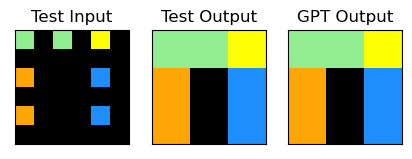

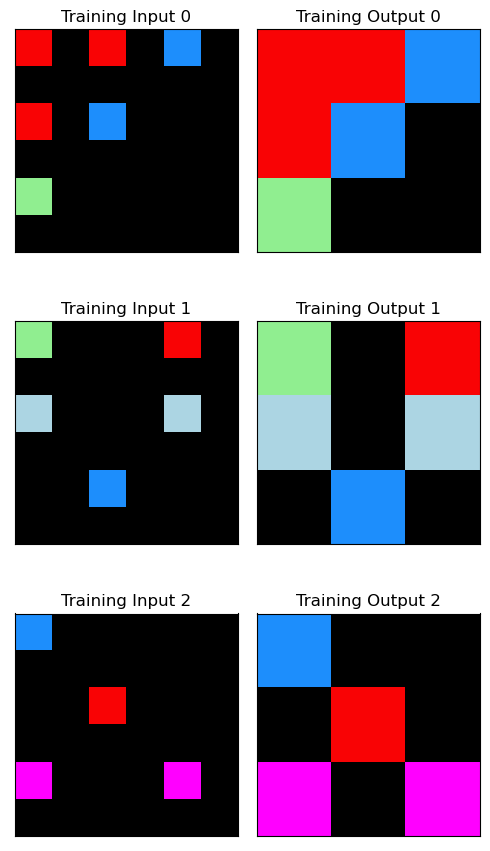

In [32]:
json_task = copy.deepcopy(myjson[task_name +'.json'])

# Add GPT output here (if any)
json_task['gpt_output'] = [
[3, 3, 4],
[7, 0, 1],
[7, 0, 1]]

# json_task['gpt_output'] = None

plot_2d_grid(json_task)